In [1]:
#In this cell, dimer files are read from the current directory
import os
import glob

file_location = os.path.join('*.pdb') #you can create your file_location with this, in this case it is not that needed

file_names = glob.glob(file_location) #file names are extracted
json_file_names = glob.glob('*.json')
print(file_names[0:5])
print(json_file_names[0:5])

['ZBTB17_ZBTB27_68bb3_unrelaxed_rank_1_model_1.pdb', 'ZBTB19_ZBTB24_50940_unrelaxed_rank_1_model_5.pdb', 'ZBTB1_ZBTB10_9eee8_unrelaxed_rank_1_model_1.pdb', 'ZBTB1_ZBTB11_afa21_unrelaxed_rank_1_model_1.pdb', 'ZBTB1_ZBTB12_be7b8_unrelaxed_rank_1_model_1.pdb']
['ZBTB17_ZBTB27_68bb3_unrelaxed_rank_1_model_1_scores.json', 'ZBTB19_ZBTB24_50940_unrelaxed_rank_1_model_5_scores.json', 'ZBTB1_ZBTB10_9eee8_unrelaxed_rank_1_model_1_scores.json', 'ZBTB1_ZBTB11_afa21_unrelaxed_rank_1_model_1_scores.json', 'ZBTB1_ZBTB12_be7b8_unrelaxed_rank_1_model_1_scores.json']


In [2]:
#In this cell, monomers are read from the monomers/ directory
import os
import glob

file_location = os.path.join('monomers/*.pdb') #directory name is stored
file_names_monomers = glob.glob('monomers/*.pdb') #pdb file names are stored
json_file_names_monomers = glob.glob('monomers/*.json') #json file names are stored

f1 = [] #for readibility f1 is created, the 'monomers\\' is deleted
for f in file_names_monomers:
    f1.append(f.replace("monomers\\",""))

print(file_names_monomers[0:5])
print(f1[0:5])

['monomers\\ZBTB10_1f1c7_unrelaxed_rank_1_model_3.pdb', 'monomers\\ZBTB11_0f367_unrelaxed_rank_1_model_4.pdb', 'monomers\\ZBTB12_8c62e_unrelaxed_rank_1_model_3.pdb', 'monomers\\ZBTB14_99749_unrelaxed_rank_1_model_5.pdb', 'monomers\\ZBTB16_a2673_unrelaxed_rank_1_model_5.pdb']
['ZBTB10_1f1c7_unrelaxed_rank_1_model_3.pdb', 'ZBTB11_0f367_unrelaxed_rank_1_model_4.pdb', 'ZBTB12_8c62e_unrelaxed_rank_1_model_3.pdb', 'ZBTB14_99749_unrelaxed_rank_1_model_5.pdb', 'ZBTB16_a2673_unrelaxed_rank_1_model_5.pdb']


In [21]:
import pandas as pd 
import re

#file_names dataframe is created, this will store dimer pdb file names...
#...the first & second monomer names in separate columns
file_names_df = pd.DataFrame(columns= ['File_Name','First_Name','Second_Name'])
i=0

for f in file_names: #iterating over dimer file_names
    match = re.search(r'ZBTB.{1,2}_ZBTB.{1,2}_',f)#get the names only
    if match: #should always work 
        match_mono_first = re.search(r'ZBTB.{1,2}_', match.group()) #get the first name
        match_mono_second = re.search(r'_ZBTB.{1,2}', match.group()) #get the second name
    else: #if it doesn't work raise error
        raise TypeError("Match is not found.")
        break
    #put them to file_names_df
    file_names_df.loc[i] = (f, match_mono_first.group().replace("_",""), match_mono_second.group().replace("_",""))
    i = i+1

#now the corresponding monomer file names for each chain of dimers (first and second) will be added to the dataframe
file_names_df["First_Monomer_File_Name"]=""
file_names_df["Second_Monomer_File_Name"]=""

#In this nested loop, monomer file names will be found
for i in range(len(file_names_df.index)): #iterating over the dataframe just created
    for f_mono in file_names_monomers: #this is the file names from monomer directory
        match = re.search(r'ZBTB.{1,2}_',f_mono)#extracting this part from monomer file names
        if match:
            if str(file_names_df.iloc[i][1]+"_") == match.group(): #if monomer name matches with the first name of the dimer
                first_monomer = str(f_mono)
            if str(file_names_df.iloc[i][2]+"_") == match.group(): #if monomer name matches with the second name of the dimer
                second_monomer = str(f_mono)
        else: #if it doesn't work raise error
            raise TypeError("Match is not found.")
            break
    file_names_df.iloc[i,3] = first_monomer
    file_names_df.iloc[i,4] = second_monomer

print(file_names_df.tail(2))
file_names_df.to_csv('figures_and_csv_1/file_names_df.csv',index=False) #file_names_df is saved
file_names_df.to_excel('figures_and_csv_1/file_names_df.xlsx',index=False) #file_names_df is saved

                                            File_Name First_Name Second_Name  \
394  ZBTB8A_ZBTB8B_56244_unrelaxed_rank_1_model_4.pdb     ZBTB8A      ZBTB8B   
395   ZBTB8A_ZBTB9_8c110_unrelaxed_rank_1_model_5.pdb     ZBTB8A       ZBTB9   

                               First_Monomer_File_Name  \
394  monomers\ZBTB8A_55e07_unrelaxed_rank_1_model_3...   
395  monomers\ZBTB8A_55e07_unrelaxed_rank_1_model_3...   

                              Second_Monomer_File_Name  
394  monomers\ZBTB8B_14ebe_unrelaxed_rank_1_model_3...  
395  monomers\ZBTB9_018ab_unrelaxed_rank_1_model_1.pdb  


In [22]:
from prody import *
from pylab import *

#to get rmsd scores of a chain from dimer and compare it to monomer this function will be used:
def get_rmsd (from_dimer, monomer): 
    matches = matchChains(from_dimer,monomer) #chains are matched
    from_dimer_ca = matches[0][0] #now the first chain is updated (coming from dimer)
    monomer_ca = matches[0][1] #monomer chain is updated
    calcTransformation(from_dimer_ca,monomer_ca).apply(from_dimer) #transformation is applied 
    rmsd = calcRMSD(from_dimer_ca,monomer_ca) #rmsd calculation is done 
    return rmsd

In [ ]:
rmsd_values_df = pd.DataFrame(columns= ['File_Name','First_Monomer_RMSD_Values','Second_Monomer_RMSD_Values'])

for i in range(len(file_names_df.index)):
    #from the file name and using prody, chain B and chain C are extracted (First and Second monomer from dimer structure)
    chain_B = prody.parsePDB(file_names_df.iloc[i][0],chain='B') 
    chain_C = prody.parsePDB(file_names_df.iloc[i][0],chain='C')
    #using chain_B and chain_C inputs and their corresponding monomer structures, rmsd scores are stored
    rmsd_first = get_rmsd(chain_B,prody.parsePDB(file_names_df.iloc[i][3]))
    rmsd_second = get_rmsd(chain_C, prody.parsePDB(file_names_df.iloc[i][4]))
    rmsd_values_df.loc[i] = (file_names_df.iloc[i][0], rmsd_first,rmsd_second)

#we will modify rmsd_values_df such that sum of the rmsd values from two chains will be represented in a new column   
rmsd_values_df["Sum_of_RMSD_Values"]= rmsd_values_df["First_Monomer_RMSD_Values"] + rmsd_values_df["Second_Monomer_RMSD_Values"]
    
rmsd_values_df = rmsd_values_df.sort_values("Sum_of_RMSD_Values") 
print(rmsd_values_df.head())

rmsd_values_df.to_csv('figures_and_csv_1/rmsd_values.csv',index=False) #rmsd values are saved
rmsd_values_df.to_excel('figures_and_csv_1/rmsd_values.xlsx',index=False) #rmsd values are saved


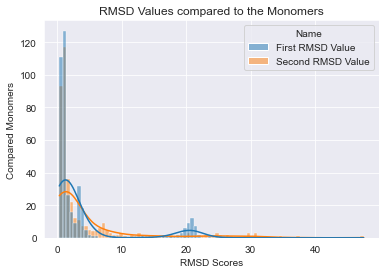

In [24]:
#Now to create a merged histogram
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

hist_df = pd.DataFrame(columns= ['Name','RMSD Values'])

for i in range(len(rmsd_values_df.index)):
    hist_df.loc[i] = ("First RMSD Value",rmsd_values_df.iloc[i][1])
    
hist_df_1 = pd.DataFrame(columns= ['Name','RMSD Values'])

for i in range(len(rmsd_values_df.index)):
    hist_df_1.loc[i] = ("Second RMSD Value",rmsd_values_df.iloc[i][2])
    
frames=[hist_df,hist_df_1]
hist_final = pd.concat(frames,ignore_index =True)

sns.set_style('darkgrid') 

g1 = sns.histplot(data=hist_final, x="RMSD Values", hue="Name",kde = True)
g1.set_title('RMSD Values compared to the Monomers')
g1.set(ylabel = "Compared Monomers", xlabel = "RMSD Scores")
plt.savefig("figures_and_csv_1/rmsd_value_hist.jpg",dpi = 500)


Freedman–Diaconis number of bins: 13


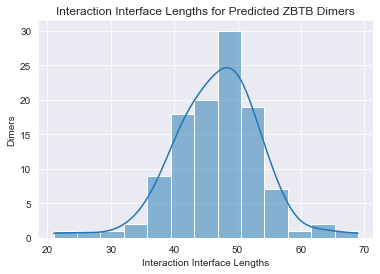

In [28]:
#In this cell, interaction_scorings_df will be imported (output of interaction_scoring_script, the file_names should be full)
#Total Interaction Interface (Residue number) will be calculated
interaction_scorings_df = pd.read_csv('interaction_scorings.csv')

#scores are omitted
interaction_scorings_df.drop(['score_from_first_chain','score_from_second_chain','final_score'], inplace=True, axis=1)

#new columns
interaction_scorings_df['length_of_interaction_site_for_first_chain']=''
interaction_scorings_df['length_of_interaction_site_for_second_chain']=''
interaction_scorings_df['length_of_interaction_site_total']=''

for i in range(len(interaction_scorings_df.index)):
    interaction_scorings_df.iloc[i,5] = len(eval(interaction_scorings_df.iloc[i,3])) #I have to use eval here to convert str to list
    interaction_scorings_df.iloc[i,6] = len(eval(interaction_scorings_df.iloc[i,4]))
    interaction_scorings_df.iloc[i,7] = int(interaction_scorings_df.iloc[i,5]) + int(interaction_scorings_df.iloc[i,6])
    
#they are sorted by final_score with ascending manner
interaction_scorings_df = interaction_scorings_df.sort_values("length_of_interaction_site_total",ascending=False) 
#interaction_scorings_df.to_csv('interaction_scorings_lengths.csv',index=False) #interaction_scoring_df is saved

final_score_list = interaction_scorings_df['length_of_interaction_site_total'].to_numpy()

#to calculate the number of 'appropiate' bins Freedman–Diaconis rule is used
q25, q75 = np.percentile(final_score_list, [25, 75])
bin_width = 2 * (q75 - q25) * len(final_score_list) ** (-1/3)
bins = round((final_score_list.max() - final_score_list.min()) / bin_width)

print("Freedman–Diaconis number of bins:", bins)

sns.set_style('darkgrid') 

g=sns.histplot(final_score_list, bins=bins, kde=True) #histogram with kde
g.set_title('Interaction Interface Lengths for Predicted ZBTB Dimers')
g.set(ylabel = "Dimers", xlabel = "Interaction Interfc Lengths")

plt.savefig("histogram_for_interaction_interface_lengths.jpg",dpi = 500)


In [61]:
#In this cell monomer PAE values will be calculated
monomers_PAE_scores = pd.DataFrame(columns= ['Monomer_File_Name','PAE_Value','Max_PAE_Value','Min_PAE_Value'])

import json
k=0
for j1 in json_file_names_monomers:
    j = open(j1)
    json_file = json.load(j) #a dictionary file is readed

    #maximum pae value is already in the dictionary
    max_pae_value = json_file['max_pae']

    #pae_values is now the 'values' of the 'pae key', it is a 2D List that goes total_chain_length X total_chain_length
    #pae_values[i][j] in here means that PAE(x,y) --> for every i there is a PAE value comparing the every other (+ itself) 
    pae_values = json_file['pae']

    #this determines the min_pae_value, i don't know if the minimum is the pae_value[i][i], maybe it is even lower than that ? 
    min_pae_value = max_pae_value
    for i in range(len(pae_values)):
        for j in range(len(pae_values)):
            min_pae_value = min(min_pae_value, pae_values[i][j])

    #interaction site combinations (x,y) from monomers should be calculated
    pae_score_total_length=0 #how many interaction combinations will be done, it should be stored
    pae_score_total = 0 #storing the total pae scoring for B
    
    #this nested loop will calculate the all calculations 
    #if residue number is n, it will calculate n*n times, and the avg score should be summedscores(n*n)/n
    for i in range(len(pae_values)):
        for j in range(len(pae_values[i])):
            pae_score_total = pae_score_total + pae_values[i][j]
            pae_score_total_length = pae_score_total_length + 1
            
    monomers_PAE_scores.loc[k] = (file_names_monomers[k],pae_score_total/pae_score_total_length,max_pae_value,min_pae_value)
    k=k+1

    
print(monomers_PAE_scores.head(2))
#monomers_PAE_scores.to_csv('monomers_PAE_scores.csv',index=False)

                                   Monomer_File_Name  PAE_Value  \
0  monomers\ZBTB10_1f1c7_unrelaxed_rank_1_model_3...  15.554792   
1  monomers\ZBTB11_0f367_unrelaxed_rank_1_model_4...   3.157077   

   Max_PAE_Value  Min_PAE_Value  
0          31.75           0.25  
1          31.75           0.25  


In [ ]:
import json

#In this cell monomers from dimers will be calculated
dimers_PAE_scores = pd.DataFrame(columns= ['File_Name','PAE_value_from_first_chain','PAE_value_from_second_chain'])

k=0
for j1 in json_file_names:
    j = open(j1)
    json_file = json.load(j) #a dictionary file is readed
    
    chain_B = prody.parsePDB(file_names[k],chain="B")
    chain_C = prody.parsePDB(file_names[k],chain="C")

    #interaction site combinations (x,y) from monomers should be calculated
    pae_score_total_length_1=0 #how many interaction combinations will be done, it should be stored
    pae_score_total_1 = 0 #storing the total pae scoring for B chain
    
    pae_score_total_length_2=0 
    pae_score_total_2 = 0 #storing the total pae scoring for C chain
    
    pae_values = json_file['pae']

    #this nested loop will calculate the all calculations !FOR THE B CHAIN!
    #if residue number is n, it will calculate n*n times, and the avg score should be summedscores(n*n)/n (FOR B CHAIN)
    for i in range(chain_B.numResidues()):
        for j in range(chain_B.numResidues()):
            pae_score_total_1 = pae_score_total_1 + pae_values[i][j]
            pae_score_total_length_1 = pae_score_total_length_1 + 1
            
    #this nested loop will calculate the all calculations !FOR THE C CHAIN!        
    for i in range(chain_B.numResidues(),(chain_B.numResidues()+chain_C.numResidues())):
        for j in range(chain_B.numResidues(),(chain_B.numResidues()+chain_C.numResidues())):
            pae_score_total_2 = pae_score_total_2 + pae_values[i][j]
            pae_score_total_length_2 = pae_score_total_length_2 + 1
            
    dimers_PAE_scores.loc[k] = (file_names[k],pae_score_total_1/pae_score_total_length_1, pae_score_total_2/pae_score_total_length_2)
    k=k+1

print(dimers_PAE_scores.head(2))
dimers_PAE_scores.to_csv('figures_and_csv_1/dimers_PAE_scores.csv',index=False)

In [27]:
#if you have to, load the dfs again
#dimers_PAE_scores = pd.read_csv("dimers_PAE_scores.csv")
monomers_PAE_scores = pd.read_csv("monomers_PAE_scores.csv")
#file_names_df = pd.read_csv("file_names_df.csv")

#Now to compare the monomers PAE vs monomers from dimers PAE -> In logarithmic Scale
PAE_comparison_df = pd.DataFrame(columns= ['File_Name','First_Monomer_PAE_Comparison','Second_Monomer_PAE_Comparison','Total_PAE_Comparison'])

for i in range(len(dimers_PAE_scores)): #iterating in dimers_PAE_scores that have file names and PAE scores for each chain
    #first we have to find the corresponding monomer file names to get PAE scores from...
    #...for that we already have file_names_df
    df = file_names_df[file_names_df["File_Name"] == str(dimers_PAE_scores.loc[i,"File_Name"])]
    df = df.reset_index(drop=True) #df now has the first and second monomer file name
    #now from the monomers_PAE_scores we will extract the PAE Value
    df_1 = monomers_PAE_scores[monomers_PAE_scores['Monomer_File_Name']== str(df.loc[0,"First_Monomer_File_Name"])]
    df_1 = df_1.reset_index(drop=True)
    #df_1 now has the PAE Value column that we can easily access...
    #additionally first_pae_log variable will store log2 of (PAE of monomer/PAE of the first chain)
    first_pae_log = np.log2(df_1.loc[0,'PAE_Value']/dimers_PAE_scores.loc[i,'PAE_value_from_first_chain'])
    #same is performed for the second chain
    df_2 = monomers_PAE_scores[monomers_PAE_scores['Monomer_File_Name']== str(df.loc[0,"Second_Monomer_File_Name"])]
    df_2 = df_2.reset_index(drop=True)
    second_pae_log = np.log2(df_2.loc[0,'PAE_Value']/dimers_PAE_scores.loc[i,'PAE_value_from_second_chain'])
    #Newly created PAE_comparison_df is stored
    PAE_comparison_df.loc[i] = (dimers_PAE_scores.iloc[i,0],first_pae_log,second_pae_log,first_pae_log+second_pae_log)
    #now to get rid of dataframes we created
    del df
    del df_1
    del df_2
    
PAE_comparison_df = PAE_comparison_df.sort_values("Total_PAE_Comparison",ascending=False) 
print(PAE_comparison_df.head(2))
PAE_comparison_df.to_csv("figures_and_csv_1/PAE_comparison.csv",index=False)
PAE_comparison_df.to_excel("figures_and_csv_1/PAE_comparison.xlsx",index=False)


                                           File_Name  \
253  ZBTB6_ZBTB26_a34fb_unrelaxed_rank_1_model_4.pdb   
277   ZBTB6_ZBTB6_76b3b_unrelaxed_rank_1_model_4.pdb   

     First_Monomer_PAE_Comparison  Second_Monomer_PAE_Comparison  \
253                      0.117152                       0.379976   
277                      0.211545                       0.207598   

     Total_PAE_Comparison  
253              0.497128  
277              0.419143  


In [37]:
import json
#This function returns average PAE values of a given file and interaction sites of that chain (!!intrachain, not interchain!!) 

def pae_value_generator(file_name,interaction_sites_for_B,interaction_sites_for_C):
    j = file_name[:-4]+"_scores.json"
    j = open(j)
    json_file = json.load(j) #a dictionary file is readed

    #pae_values is now the 'values' of the 'pae key', it is a 2D List that goes total_chain_length X total_chain_length
    #pae_values[i][j] in here means that PAE(x,y) --> for every i there is a PAE value comparing the every other (+ itself) 
    pae_values = json_file['pae']

    #interaction site combinations (x,y) from interaction_sites_B & interaction_sites_C should be compared!
    pae_score_total_B_length=0 #how many interaction combinations will be done, it should be stored
    pae_score_total_B = 0 #storing the total pae scoring for B
    for interaction_site_for_B in interaction_sites_for_B:
        for interaction_site_for_B_compare in interaction_sites_for_B:
            pae_score_total_B = pae_score_total_B + pae_values[interaction_site_for_B-1][interaction_site_for_B_compare-1] #this compares every B to every C
            pae_score_total_B_length = pae_score_total_B_length + 1 #updates the interaction combination

    #interaction site combinations (x,y) from interaction_sites_C & interaction_sites_B should be compared!
    pae_score_total_C_length=0 #how many interaction combinations will be done, it should be stored
    pae_score_total_C = 0 #storing the total pae scoring for C
    for interaction_site_for_C in interaction_sites_for_C:
        for interaction_site_for_C_compare in interaction_sites_for_C:
            pae_score_total_C = pae_score_total_C + pae_values[interaction_site_for_C-1][interaction_site_for_C_compare-1] #this compares every C to every B
            pae_score_total_C_length = pae_score_total_C_length + 1 #updates the interaction combination

    return (zero_div(pae_score_total_B,pae_score_total_B_length), zero_div(pae_score_total_C,pae_score_total_C_length)) 

#when calculating the monomer PAE value, 0 value should be returned for one of the PAE scores
def zero_div(x, y):
    if y: return x / y
    else: return 0

In [46]:
import pandas as pd
import numpy as np

#Now to compare the monomers !!IF!! PAE vs monomers from dimers PAE -> In logarithmic Scale
IFPAE_comparison_df = pd.DataFrame(columns= ['File_Name','First_Monomer_IFPAE_Comparison','Second_Monomer_IFPAE_Comparison','Total_IFPAE_Comparison'])

#if you have to, load the dfs again

file_names_df = pd.read_csv("figures_and_csv_1/file_names_df.csv")
interaction_scorings_df = pd.read_csv("figures_and_csv_1/interaction_scorings.csv")

for i in range(len(file_names_df)):
    #first we have to find the corresponding monomer file names to get interaction scores from...
    #...for that we already have interaction_scorings_df
    df = interaction_scorings_df[interaction_scorings_df['Name']== str(file_names_df.loc[i,"File_Name"])]
    df = df.reset_index(drop=True)
    empty_list = []
    #dimer IFPAE scores will be extracted
    IFPAE_of_B , IFPAE_of_C = pae_value_generator(str(df.loc[0,"Name"]), eval(df.loc[0,"interaction_sites_for_first_chain"]),eval(df.loc[0,"interaction_sites_from_second_chain_modified"]))
    IFPAE_of_B_mono , empty = pae_value_generator(str(file_names_df.loc[i,"First_Monomer_File_Name"]),eval(df.loc[0,"interaction_sites_for_first_chain"]),empty_list)
    empty , IFPAE_of_C_mono = pae_value_generator(str(file_names_df.loc[i,"Second_Monomer_File_Name"]),empty_list,eval(df.loc[0,"interaction_sites_for_second_chain"]))
    #additionally first_pae_log variable will store log2 of (PAE of monomer/PAE of the first chain)
    first_pae_log = np.log2(IFPAE_of_B_mono/IFPAE_of_B)
    second_pae_log = np.log2(IFPAE_of_C_mono/IFPAE_of_C)
    #Newly created PAE_comparison_df is stored
    IFPAE_comparison_df.loc[i] = (df.loc[0,"Name"],first_pae_log,second_pae_log,first_pae_log+second_pae_log)
    #now to get rid of dataframe we created
    del df

IFPAE_comparison_df = IFPAE_comparison_df.sort_values("Total_IFPAE_Comparison",ascending=False) 
print(IFPAE_comparison_df.tail(2))
IFPAE_comparison_df.to_csv("figures_and_csv_1/IFPAE_comparison.csv",index=False)
IFPAE_comparison_df.to_excel("figures_and_csv_1/IFPAE_comparison.xlsx",index=False)


                                            File_Name  \
354  ZBTB7B_ZBTB40_6e2a6_unrelaxed_rank_1_model_5.pdb   
346  ZBTB7B_ZBTB32_e39bd_unrelaxed_rank_1_model_5.pdb   

     First_Monomer_IFPAE_Comparison  Second_Monomer_IFPAE_Comparison  \
354                       -1.313035                        -1.018545   
346                       -0.525498                        -1.813489   

     Total_IFPAE_Comparison  
354               -2.331580  
346               -2.338987  


Freedman–Diaconis number of bins: 17


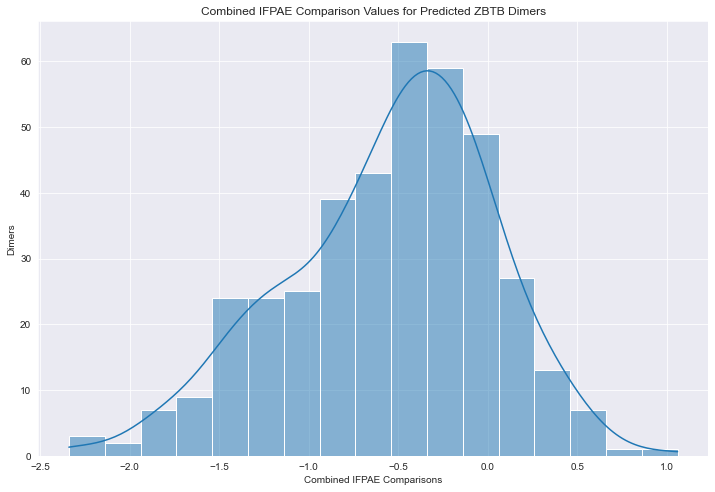

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

final_score_list = IFPAE_comparison_df['Total_IFPAE_Comparison'].to_numpy()

#to calculate the number of 'appropiate' bins Freedman–Diaconis rule is used
q25, q75 = np.percentile(final_score_list, [25, 75])
bin_width = 2 * (q75 - q25) * len(final_score_list) ** (-1/3)
bins = round((final_score_list.max() - final_score_list.min()) / bin_width)

print("Freedman–Diaconis number of bins:", bins)

sns.set_style('darkgrid') 
plt.figure(figsize=(12,8))
g=sns.histplot(final_score_list, bins=bins, kde=True) #histogram with kde
g.set_title('Combined IFPAE Comparison Values for Predicted ZBTB Dimers')
g.set(ylabel = "Dimers", xlabel = "Combined IFPAE Comparisons")

plt.savefig("figures_and_csv_1/histogram_for_IFPAE_comparison.jpg",dpi = 500)


@> 997 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 894 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 894 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 997 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Checking AtomGroup ZBTB27_ZBTB17_44116_unrelaxed_rank_1_model_1C: 1 chains are identified
@> Checking AtomGroup ZBTB17_4eaca_unrelaxed_rank_1_model_4: 1 chains are identified
@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain C from ZBTB27_ZBTB17_44116_unrelaxed_rank_1_model_1C (len=115) and Chain A from ZBTB17_4eaca_unrelaxed_rank_1_model_4 (len=115):
@> 	Match: 115 residues match with 100% sequence identity and 100% overlap.
@> WARNING mobile is an AtomMap instance, consider assign weights=mobile.getFlags("mapped") if there are dummy atoms in mobile
@> WARNING target is an AtomMap instance, consider assign weights=target.getFlags("mapped") if there are dummy atoms in target


Chain 1     : AtomMap Chain C from ZBTB27_ZBTB17_44116_unrelaxed_rank_1_model_1C -> Chain A from ZBTB17_4eaca_unrelaxed_rank_1_model_4
Chain 2     : AtomMap Chain A from ZBTB17_4eaca_unrelaxed_rank_1_model_4 -> Chain C from ZBTB27_ZBTB17_44116_unrelaxed_rank_1_model_1C
Length      : 115
Seq identity: 100.0
Seq overlap : 100.0
RMSD        : 20.704736241403488

0.6522043599719054


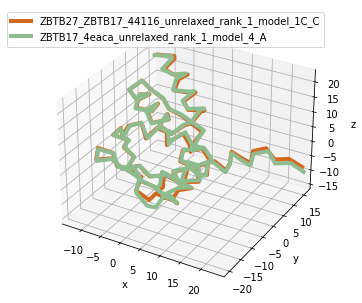

In [4]:
#AN EXAMPLE OF PRODY RMSD CALCULATION:
from prody import *
from pylab import *

#matching the chains to get transformed RMSD values of ZBTB1 BTB Domain in two instances
chain_B = prody.parsePDB("ZBTB27_ZBTB17_44116_unrelaxed_rank_1_model_1.pdb",chain='B') 
chain_C = prody.parsePDB("ZBTB27_ZBTB17_44116_unrelaxed_rank_1_model_1.pdb",chain='C')

zbtb17= prody.parsePDB("monomers/ZBTB17_4eaca_unrelaxed_rank_1_model_4.pdb")
zbtb27= prody.parsePDB("monomers/ZBTB27_2e9db_unrelaxed_rank_1_model_5.pdb")

matches = matchChains(chain_C, zbtb17)#matching is performed

def printMatch(match): #this is useful in printing
    print('Chain 1     : {}'.format(match[0]))
    print('Chain 2     : {}'.format(match[1]))
    print('Length      : {}'.format(len(match[0])))
    print('Seq identity: {}'.format(match[2]))
    print('Seq overlap : {}'.format(match[3]))
    print('RMSD        : {}\n'.format(calcRMSD(match[0], match[1])))

for match in matches: #printing the matching 
    printMatch(match)
    
chain_C_ca = matches[0][0] #this is for chain_B matched with Carbon alpha atoms
zbtb17_ca = matches[0][1] #this is for chain_C matched with Carbon alpha atoms

calcTransformation(chain_C_ca, zbtb17_ca).apply(chain_C) #transformation of chain_B
print(calcRMSD(chain_C_ca, zbtb17_ca)) #RMSD calculation after transformation

showProtein(chain_C_ca, zbtb17_ca)
legend()